# Quantum Variational Circuits and Quantum Neural Networks

In some cases QNN is a fitting name when we inherit the structure from classical neutral networks. Nevertheless, in some cases, the structure could be different. For example, a classical NN loads all data into the first layer, whereas quantum circuits might start with some data in the first layer and load more data later (reuploading).

This lesson will be about:
* Loading data from an image into a quantum circuit
* Constructing an ansatz for a VQC (Or QNN), and adjusting it to fit the problem
* Training your VQC/QNN and using it to make accurate predicdtions on test data
* Scaling the problem, and recognizing limits of current quantum computers

## Data generation

We will first construct the data. Therefore, we write the following code:

In [2]:
# This code defines the images to be classified:
 
import numpy as np
 
# Total number of "pixels"/qubits
size = 8
# One dimension of the image (called vertical, but it doesn't matter). Must be a divisor of `size`
vert_size = 2
# The length of the line to be detected (yellow). Must be less than or equal to the smallest dimension of the image (`<=min(vert_size,size/vert_size)`
line_size = 2
 
 
def generate_dataset(num_images):
    images = []
    labels = []
    hor_array = np.zeros((size - (line_size - 1) * vert_size, size))
    ver_array = np.zeros((round(size / vert_size) * (vert_size - line_size + 1), size))
 
    j = 0
    for i in range(0, size - 1):
        if i % (size / vert_size) <= (size / vert_size) - line_size:
            for p in range(0, line_size):
                hor_array[j][i + p] = np.pi / 2
            j += 1
 
    # Make two adjacent entries pi/2, then move down to the next row. Careful to avoid the "pixels" at size/vert_size - linesize, because we want to fold this list into a grid.
 
    j = 0
    for i in range(0, round(size / vert_size) * (vert_size - line_size + 1)):
        for p in range(0, line_size):
            ver_array[j][i + p * round(size / vert_size)] = np.pi / 2
        j += 1
 
    # Make entries pi/2, spaced by the length/rows, so that when folded, the entries appear on top of each other.
 
    for n in range(num_images):
        rng = np.random.randint(0, 2)
        if rng == 0:
            labels.append(-1)
            random_image = np.random.randint(0, len(hor_array))
            images.append(np.array(hor_array[random_image]))
 
        elif rng == 1:
            labels.append(1)
            random_image = np.random.randint(0, len(ver_array))
            images.append(np.array(ver_array[random_image]))
            # Randomly select 0 or 1 for a horizontal or vertical array, assign the corresponding label.
 
        # Create noise
        for i in range(size):
            if images[-1][i] == 0:
                images[-1][i] = np.random.rand() * np.pi / 4
    return images, labels
 
 
hor_size = round(size / vert_size)

The code defines a data set of images with set pixel dimensions. Above, we defined an image of 8 pixels, with two rows of 4 pixels each. The yellow line is drawn over 2 pixels. We have images with horizontal yellow lines, as well as vertical yellow lines. These images are labeled as +1 for vertical, and -1 for horizontal.

We will make use of `sklearn` to split a data set of 100 images into training (70) and test set (30), along with their corresponding labels.

In [3]:
from sklearn.model_selection import train_test_split
 
np.random.seed(42)
images, labels = generate_dataset(200)
 
train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.3, random_state=246
)

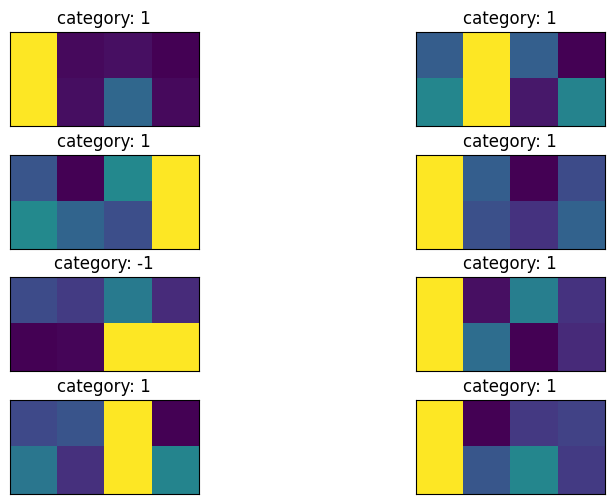

In [4]:
import matplotlib.pyplot as plt
 
# Make subplot titles so we can identify categories
titles = []
for i in range(8):
    title = "category: " + str(train_labels[i])
    titles.append(title)
 
# Generate a figure with nested images using subplots.
fig, ax = plt.subplots(4, 2, figsize=(10, 6), subplot_kw={"xticks": [], "yticks": []})
 
for i in range(8):
    ax[i // 2, i % 2].imshow(
        train_images[i].reshape(vert_size, hor_size),
        aspect="equal",
    )
    ax[i // 2, i % 2].set_title(titles[i])
plt.subplots_adjust(wspace=0.1, hspace=0.3)

Each image is still labeled with its `train_labels`:

In [5]:
print(train_labels[:8])

[1, 1, 1, 1, -1, 1, 1, 1]


# Variational quantum classifier: a first attempt

## Qiskit patterns step 1: Map the problem to a quantum circuit

What we would like to achieve is to find a mapping of the data vector/image $\vec{x}$ to the correct category of the form $f_\theta (\vec{x})\to \pm 1$ with parameters $\theta$ determined during training. A VQC represents one way of accomplishing this, with a few layers that can be identified by their distinct purposes:
\begin{equation}
f_\theta(\vec{x})=\langle 0|U^\dagger(\vec{x})W^\dagger(\theta)OW(\theta)U(\vec{x})|0\rangle
\end{equation}
As discussed before, the data is encoded with an encoding circuit $U(\vec{x})$. $W(\theta)$ is a variational, or trainable circuit block, where the parameters $\theta$ will be trained, and varied by classical optimization algorithms. Finally, $O$ is some observable taht will be estimated using the Estimator primitive. The structure is not strictly set. We could have several layers, and in any order that is technically motivated.

Let's start with a feature map, where we choose `z_feature_map`

In [6]:
from qiskit.circuit.library import z_feature_map
 
# One qubit per data feature
num_qubits = len(train_images[0])
 
# Data encoding
# Note that qiskit orders parameters alphabetically. We assign the parameter prefix "a" to ensure our data encoding goes to the first part of the circuit, the feature mapping.
feature_map = z_feature_map(num_qubits, parameter_prefix="a")

The ansatz for our training will be determined after making the following considerations:

1. Hardware: All modern quantum computers are more prone to errors and more susceptible to noise than their classical counterparts. Hence, we try to avoid an excessively deep circuit. Furthermore, the qubit layout might play a role, meaning that some physical qubits are adjacent on the quantum computer, and others may be very far from each other. Entangling very distant qubits increases the depth substantially, as swap gates must be inserted to move information.
2. The problem: Any valuable information about the problem might help with finding the right ansatz. For example, in our case, the structure of the pixels could be used somehow.
3. Number of parameters: ``Barren plateaus`` happens where the optimization of variational quantum algorithms becomes exponentially flat and featureless as the problem size increases. With vanishing gradients, it will be difficult to train the algorithm. One reason for that is the number of parameters. But also other considerations like the global cost functions and random parameter initialization play a role in avoiding barren plateaus.

We use entanglement and CNOT gates between qubits corresponding to adjacent pixels.

5
2+ qubit depth: 3


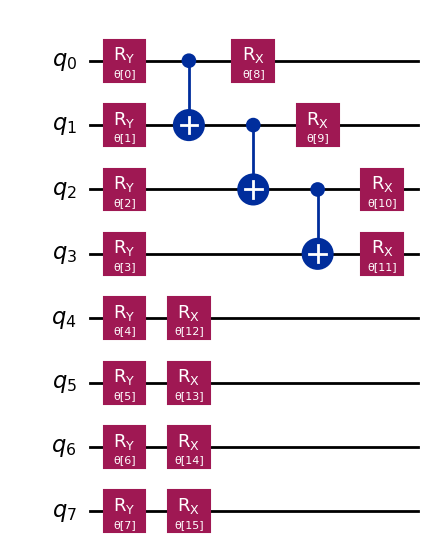

In [7]:
# Import the necessary packages
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
 
# Initialize the circuit using the same number of qubits as the image has pixels
qnn_circuit = QuantumCircuit(size)
 
# We choose to have two variational parameters for each qubit.
params = ParameterVector("θ", length=2 * size)
 
# A first variational layer:
for i in range(size):
    qnn_circuit.ry(params[i], i)
 
# Here is a list of qubit pairs between which we want CNOT gates. The choice of these is not yet obvious.
qnn_cnot_list = [[0, 1], [1, 2], [2, 3]]
 
for i in range(len(qnn_cnot_list)):
    qnn_circuit.cx(qnn_cnot_list[i][0], qnn_cnot_list[i][1])
 
# The second variational layer:
for i in range(size):
    qnn_circuit.rx(params[size + i], i)
 
# Check the circuit depth, and the two-qubit gate depth
print(qnn_circuit.decompose().depth())
print(
    f"2+ qubit depth: {qnn_circuit.decompose().depth(lambda instr: len(instr.qubits) > 1)}"
)
 
# Draw the circuit
qnn_circuit.draw("mpl")

Our QNN ansatz will be the following:

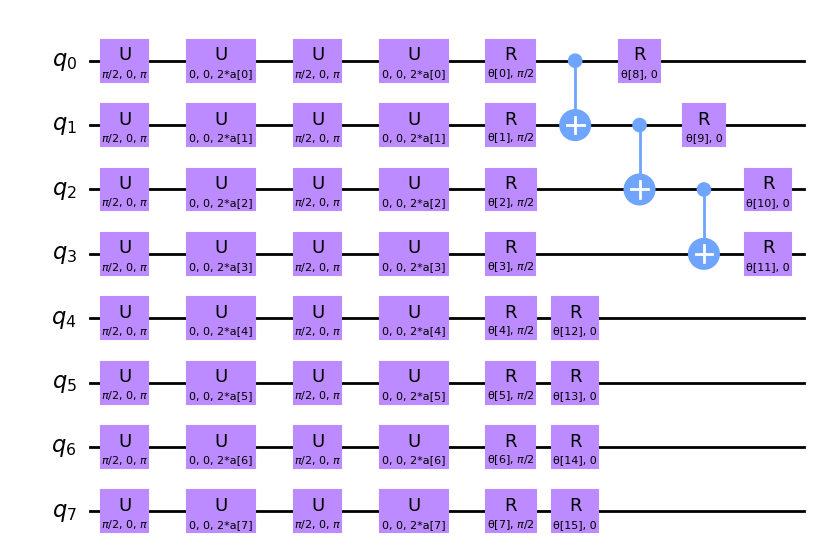

In [8]:
# QNN ansatz
ansatz = qnn_circuit
 
# Combine the feature map with the ansatz
full_circuit = QuantumCircuit(num_qubits)
full_circuit.compose(feature_map, range(num_qubits), inplace=True)
full_circuit.compose(ansatz, range(num_qubits), inplace=True)
 
# Display the circuit
full_circuit.decompose().draw("mpl", style="clifford", fold=-1)

Now, we need to define an observable that can be used in the cost function. An expectation value can be obtained with `Estimator`. With a good ansatz, each qubit will contain information relevant to classification. With additional ``convolutional layers`` information can be condensed into fewer qubits, such that the measurements are only needed on a subset of qubits. Another possibility is that one can measure some attribute from each qubit. We will use the latter approach and include a `Z` operator for each qubit, because:

* $Z$ can yield two possible outcomes, which is perfect fora binary classification task
* The eigenvalues of $Z$ ($\pm 1$) are reasonably well separated, and result in an estimator outcome in interval $[-1,+1]$, where 0 can simply be used as a cutoff value.
* It is straightforward to measure in Pauli Z basis with no extra gate overhead. 

In [9]:
from qiskit.quantum_info import SparsePauliOp
 
observable = SparsePauliOp.from_list([("Z" * (num_qubits), 1)])

Next, we need a function to run a forward pass. In the function below, the `input_params` and `weight_params` are taken separately.

In [10]:
from qiskit.primitives import BaseEstimatorV2
from qiskit.quantum_info.operators.base_operator import BaseOperator
 
 
def forward(
    circuit: QuantumCircuit,
    input_params: np.ndarray,
    weight_params: np.ndarray,
    estimator: BaseEstimatorV2,
    observable: BaseOperator,
) -> np.ndarray:
    """
    Forward pass of the neural network.
 
    Args:
        circuit: circuit consisting of data loader gates and the neural network ansatz.
        input_params: data encoding parameters.
        weight_params: neural network ansatz parameters.
        estimator: EstimatorV2 primitive.
        observable: a single observable to compute the expectation over.
 
    Returns:
        expectation_values: an array (for one observable) or a matrix (for a sequence of observables) of expectation values.
        Rows correspond to observables and columns to data samples.
    """
    num_samples = input_params.shape[0]
    weights = np.broadcast_to(weight_params, (num_samples, len(weight_params)))
    params = np.concatenate((input_params, weights), axis=1)
    pub = (circuit, observable, params)
    job = estimator.run([pub])
    result = job.result()[0]
    expectation_values = result.data.evs
 
    return expectation_values

## Loss function

Among various different loss functions, we choose the means squared difference, to calculate the difference between the predicted and calculated values of the labels.

In [11]:
def mse_loss(predict: np.ndarray, target: np.ndarray) -> np.ndarray:
    """
    Mean squared error (MSE).
 
    prediction: predictions from the forward pass of neural network.
    target: true labels.
 
    output: MSE loss.
    """
    if len(predict.shape) <= 1:
        return ((predict - target) ** 2).mean()
    else:
        raise AssertionError("input should be 1d-array")

For a slightly different loss function, we implement a function that only takes the ansatz parameters as input, while other variables for the forward pass and the loss are set as global parameters.

In [12]:
def mse_loss_weights(weight_params: np.ndarray) -> np.ndarray:
    """
    Cost function for the optimizer to update the ansatz parameters.
 
    weight_params: ansatz parameters to be updated by the optimizer.
 
    output: MSE loss.
    """
    predictions = forward(
        circuit=circuit,
        input_params=input_params,
        weight_params=weight_params,
        estimator=estimator,
        observable=observable,
    )
 
    cost = mse_loss(predict=predictions, target=target)
    objective_func_vals.append(cost)
 
    global iter
    if iter % 50 == 0:
        print(f"Iter: {iter}, loss: {cost}")
    iter += 1
 
    return cost

We will use COBYLA as a classical optimizer to minimize the cost function through choosing the weights accordingly:

In [13]:
from scipy.optimize import minimize

In [14]:
# Globals
circuit = full_circuit
observables = observable
# input_params = train_images_batch
# target = train_labels_batch
objective_func_vals = []
iter = 0

# Qiskit Patterns Step 2: Optimize problem for quantum execution

Select a backend:

In [15]:
from qiskit_ibm_runtime import QiskitRuntimeService
 
service = QiskitRuntimeService()
backend = service.least_busy(operational=True, simulator=False)
print(backend.name)

management.get:WARNING:2026-02-06 16:23:44,653: Loading default saved account


ibm_torino


We specify the `optimization_level` and add dynamical decoupling. The code below generates a pass manager using preset pass managers from `qiskit.transpiler`

In [16]:
from qiskit.circuit.library import XGate
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import (
    ALAPScheduleAnalysis,
    ConstrainedReschedule,
    PadDynamicalDecoupling,
)
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
 
target = backend.target
 
pm = generate_preset_pass_manager(target=target, optimization_level=3)
pm.scheduling = PassManager(
    [
        ALAPScheduleAnalysis(target=target),
        ConstrainedReschedule(
            acquire_alignment=target.acquire_alignment,
            pulse_alignment=target.pulse_alignment,
            target=target,
        ),
        PadDynamicalDecoupling(
            target=target,
            dd_sequence=[XGate(), XGate()],
            pulse_alignment=target.pulse_alignment,
        ),
    ]
)

Now we use the pass manager on the circuit:

In [17]:
circuit_ibm = pm.run(full_circuit)
observable_ibm = observable.apply_layout(circuit_ibm.layout)

# Qiskit Patterns Step 3: Execute using Qiskit Primitives

## Loop over the dataset in batches and epochs

We implement the full algorithm using a simulator for cursory debugging and for estimates of error. We can go over the entire dataset in batches in desired number of epochs to train our QNN

In [18]:
from qiskit.primitives import StatevectorEstimator as Estimator
 
batch_size = 140
num_epochs = 1
num_samples = len(train_images)
 
# Globals
circuit = full_circuit
estimator = Estimator()  # simulator for debugging
observables = observable
objective_func_vals = []
iter = 0
 
# Random initial weights for the ansatz
np.random.seed(42)
weight_params = np.random.rand(len(ansatz.parameters)) * 2 * np.pi
 
for epoch in range(num_epochs):
    for i in range((num_samples - 1) // batch_size + 1):
        print(f"Epoch: {epoch}, batch: {i}")
        start_i = i * batch_size
        end_i = start_i + batch_size
        train_images_batch = np.array(train_images[start_i:end_i])
        train_labels_batch = np.array(train_labels[start_i:end_i])
        input_params = train_images_batch
        target = train_labels_batch
        iter = 0
        res = minimize(
            mse_loss_weights, weight_params, method="COBYLA", options={"maxiter": 100}
        )
        weight_params = res["x"]

Epoch: 0, batch: 0
Iter: 0, loss: 1.0002309063537163
Iter: 50, loss: 0.9434121445009018


# Qiskit Patterns Step 4: Post-process, return result in classical format

## Testing and accuracy

We now interpret the results from training. We first test the training accuracy over the training set

In [19]:
import copy
from sklearn.metrics import accuracy_score
from qiskit.primitives import StatevectorEstimator as Estimator  # simulator
# from qiskit_ibm_runtime import EstimatorV2 as Estimator  # real quantum computer
 
estimator = Estimator()
# estimator = Estimator(backend=backend)
 
pred_train = forward(circuit, np.array(train_images), res["x"], estimator, observable)
# pred_train = forward(circuit_ibm, np.array(train_images), res['x'], estimator, observable_ibm)
 
print(pred_train)
 
pred_train_labels = copy.deepcopy(pred_train)
pred_train_labels[pred_train_labels >= 0] = 1
pred_train_labels[pred_train_labels < 0] = -1
print(pred_train_labels)
print(train_labels)
 
accuracy = accuracy_score(train_labels, pred_train_labels)
print(f"Train accuracy: {accuracy * 100}%")

[-2.27688499e-02 -1.46227204e-02 -1.73927452e-02  9.93331786e-02
 -4.85553548e-01  1.43558565e-01  8.34567054e-02 -1.40133992e-02
  1.52169596e-01 -1.95082515e-01  8.24373578e-03 -9.90696638e-02
 -3.54268344e-02 -4.77017954e-01  1.38713848e-02 -2.99706215e-01
 -5.78378029e-02  3.25528779e-02 -4.11354239e-02 -1.06483708e-01
  1.53095800e-01  2.90110884e-02  1.25745450e-02  6.46323079e-02
 -1.53538943e-01 -1.57694952e-02 -1.67800067e-02 -1.99820822e-01
  1.70360075e-01  7.86148038e-03 -2.33373818e-02  6.64233020e-02
 -1.14895445e-01 -1.11296215e-01  1.15120303e-01 -2.94096140e-01
 -1.00531392e-03 -1.69209726e-01 -1.26120885e-01  3.26298176e-02
 -1.33517383e-02 -5.86983444e-02 -4.32341361e-01 -4.36509551e-01
 -4.17940102e-02  1.76935235e-03  8.14479984e-03  1.86985655e-01
 -2.75525019e-01 -1.63229907e-03 -1.08571055e-01 -7.37452387e-04
 -6.44440657e-02  6.72812834e-04  2.16785530e-03  1.41381850e-01
 -9.82570410e-02  4.35973325e-01 -7.62261965e-02 -1.86193980e-01
 -1.56971183e-02 -4.02757

Only 60% training accuracy is not good and likely won't be better on the test set

In [20]:
pred_test = forward(circuit, np.array(test_images), res["x"], estimator, observable)
# pred_test = forward(circuit_ibm, np.array(test_images), res['x'], estimator, observable_ibm)
 
print(pred_test)
 
pred_test_labels = copy.deepcopy(pred_test)
pred_test_labels[pred_test_labels >= 0] = 1
pred_test_labels[pred_test_labels < 0] = -1
print(pred_test_labels)
print(test_labels)
 
accuracy = accuracy_score(test_labels, pred_test_labels)
print(f"Test accuracy: {accuracy * 100}%")

[-2.77978120e-01 -2.62194862e-01  4.59636095e-02 -8.09344165e-02
 -2.97362966e-01  9.22947242e-02  2.06693174e-01  3.31629460e-02
  1.10971762e-03 -2.14602152e-01 -1.62671993e-01 -6.07179155e-04
 -1.59948633e-01 -8.55722523e-02 -1.13057027e-01 -3.00187433e-01
 -2.92832827e-01  7.38580629e-02 -6.03706270e-02 -8.57643552e-02
 -1.52402062e-02 -3.57505447e-01 -3.54890597e-02  1.36534749e-01
 -1.54688180e-01 -2.93714726e-01  1.89548513e-02 -6.15715564e-02
  1.11042670e-01 -2.22861100e-02 -3.84230105e-02  1.67351034e-01
 -8.38766333e-02  2.56348613e-01 -1.10653111e-01 -1.18989476e-01
 -6.75723266e-05 -6.88580547e-02  1.02431393e-02 -2.42125353e-01
 -1.09142367e-01 -1.22540757e-01 -1.63735850e-01  3.93334838e-01
  2.36705685e-01 -2.34259814e-02 -3.91877756e-02 -1.95106746e-01
  1.86707523e-01  4.74775215e-02 -4.24907432e-02 -2.06453265e-01
  4.09184710e-02 -3.54762080e-02 -9.47513112e-02  2.97270112e-01
 -2.99708696e-02  9.93941064e-03 -1.26760302e-01 -1.36183355e-01]
[-1. -1.  1. -1. -1.  1.

What are the reasons for performing so poorly? To find out, we should ask:

* Did we stop the training too soon? Were more optimization steps needed?
* Did we construct a bad ansatz? This could mean a lot of things. When we work on real quantum computers, circuit depth will be a major consideration. The number of paramters is also potentially important, as is the entangling between qubits.
* Combining the two above, did we construct an ansatz with too many parameters to be trainable?

Let's check if the optimization converged:

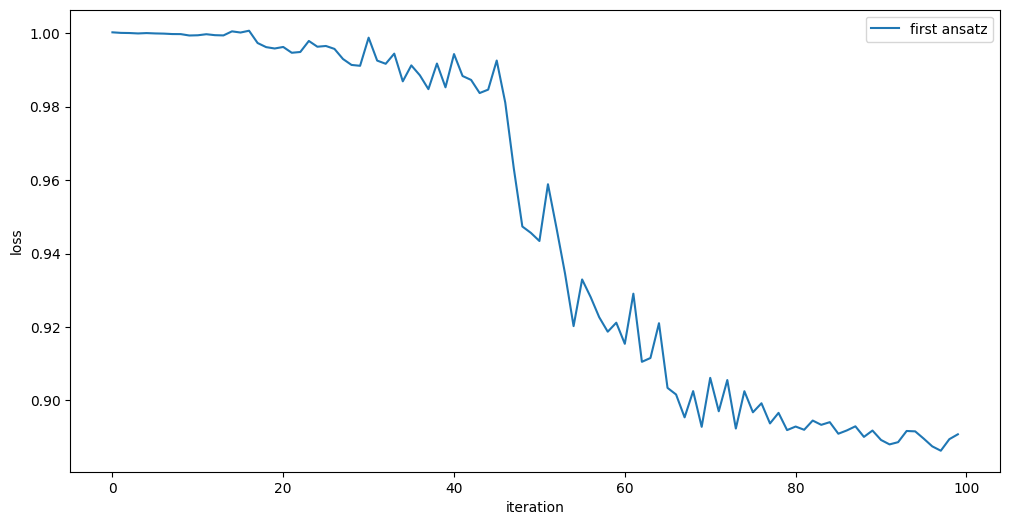

In [21]:
obj_func_vals_first = objective_func_vals
# import matplotlib.pyplot as plt
 
plt.figure(figsize=(12, 6))
plt.plot(obj_func_vals_first, label="first ansatz")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.legend()
plt.show()

We could extend the optimization steps to make sure that the optimizer didn't get stuck in a local minimum. But it looks fairly converged. Let's have a look at images that were classified incorrectly: 

In [22]:
missed = []
for i in range(len(test_labels)):
    if pred_test_labels[i] != test_labels[i]:
        missed.append(test_images[i])
print(len(missed))

24


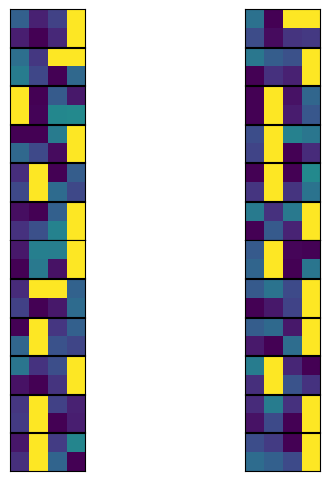

In [23]:
fig, ax = plt.subplots(12, 2, figsize=(6, 6), subplot_kw={"xticks": [], "yticks": []})
for i in range(len(missed)):
    ax[i // 2, i % 2].imshow(
        missed[i].reshape(vert_size, hor_size),
        aspect="equal",
    )
plt.subplots_adjust(wspace=0.02, hspace=0.025)

Most images have vertical lines. Let's look at this more closely.

## Improving the model

### Step 1 revisited

We might find some problems already in the very beginning, where we were mapping the problem to a quantum circuit. Horizontally, we would like to know that "if pixel $i$ is yellow, is pixel $i+1$ yellow". We also want to know this correlation about vertical lines. So far CNOTs are implemented between 0 and 1, 1 and 2, and 2 and 3. That's just the first horizontal line. So we would like to cover the lower row as well with CNOTs. To address vertical lines CNOTs betwen 0 and 4, or 2 and 6 would be usefull as well. But first, let's check the horizontal shortcoming

5
2+ qubit depth: 3


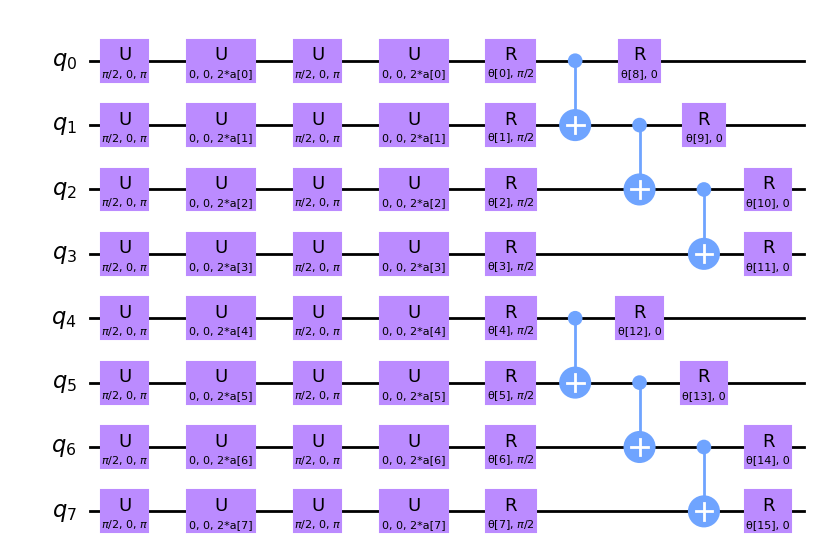

In [24]:
# Initialize the circuit using the same number of qubits as the image has pixels
qnn_circuit = QuantumCircuit(size)
 
# We choose to have two variational parameters for each qubit.
params = ParameterVector("θ", length=2 * size)
 
# A first variational layer:
for i in range(size):
    qnn_circuit.ry(params[i], i)
 
# Here is an extended list of qubit pairs between which we want CNOT gates. This now covers all pixels connected by horizontal lines.
qnn_cnot_list = [[0, 1], [1, 2], [2, 3], [4, 5], [5, 6], [6, 7]]
 
for i in range(len(qnn_cnot_list)):
    qnn_circuit.cx(qnn_cnot_list[i][0], qnn_cnot_list[i][1])
 
# The second variational layer:
for i in range(size):
    qnn_circuit.rx(params[size + i], i)
 
# Check the circuit depth, and the two-qubit gate depth
print(qnn_circuit.decompose().depth())
print(
    f"2+ qubit depth: {qnn_circuit.decompose().depth(lambda instr: len(instr.qubits) > 1)}"
)
 
# Combine the feature map and variational circuit
ansatz = qnn_circuit
 
# Combine the feature map with the ansatz
full_circuit = QuantumCircuit(num_qubits)
full_circuit.compose(feature_map, range(num_qubits), inplace=True)
full_circuit.compose(ansatz, range(num_qubits), inplace=True)
 
# Display the circuit
full_circuit.decompose().draw("mpl", style="clifford", fold=-1)

### Step 2 revisited

Let's go deeper into transpilation later

### Step 3 revisited

Let's apply the updated model to our training data

In [25]:
from qiskit.primitives import StatevectorEstimator as Estimator
 
batch_size = 140
num_epochs = 1
num_samples = len(train_images)
 
# Globals
circuit = full_circuit
estimator = Estimator()  # simulator for debugging
observables = observable
objective_func_vals = []
iter = 0
 
# Random initial weights for the ansatz
np.random.seed(42)
weight_params = np.random.rand(len(ansatz.parameters)) * 2 * np.pi
 
for epoch in range(num_epochs):
    for i in range((num_samples - 1) // batch_size + 1):
        print(f"Epoch: {epoch}, batch: {i}")
        start_i = i * batch_size
        end_i = start_i + batch_size
        train_images_batch = np.array(train_images[start_i:end_i])
        train_labels_batch = np.array(train_labels[start_i:end_i])
        input_params = train_images_batch
        target = train_labels_batch
        iter = 0
        res = minimize(
            mse_loss_weights, weight_params, method="COBYLA", options={"maxiter": 100}
        )
        weight_params = res["x"]

Epoch: 0, batch: 0
Iter: 0, loss: 1.0049762969140237
Iter: 50, loss: 0.8274276543780369


### Step 4 revisited

Let's check the convergence again

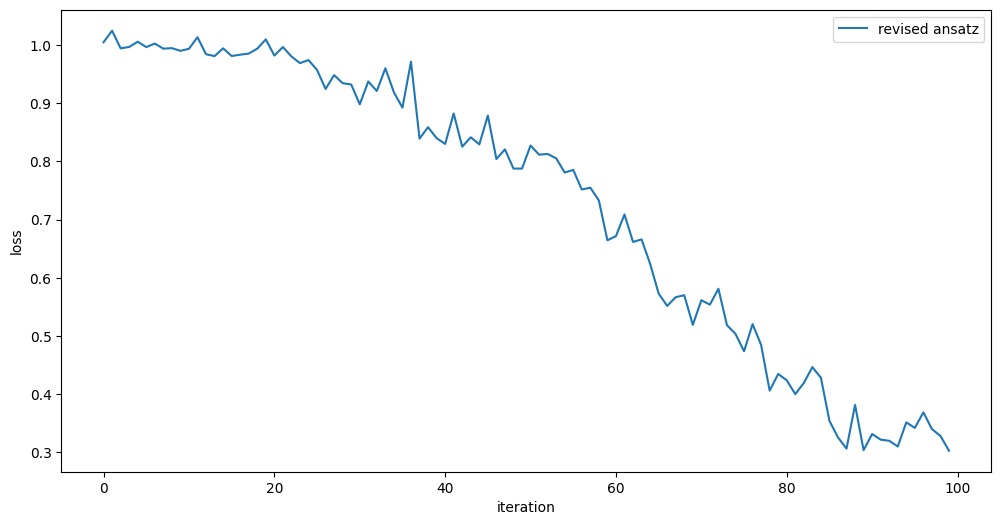

In [26]:
obj_func_vals_revised = objective_func_vals
# import matplotlib.pyplot as plt
 
plt.figure(figsize=(12, 6))
plt.plot(obj_func_vals_revised, label="revised ansatz")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.legend()
plt.show()

This does not look like convergence. But the loss function is much lower than before. It would be advantageous to ensure convergence. But let's move on for now and say that it's sufficient. Next, let's look at the accuracy on our training data and testing data

In [27]:
from sklearn.metrics import accuracy_score
from qiskit.primitives import StatevectorEstimator as Estimator  # simulator
# from qiskit_ibm_runtime import EstimatorV2 as Estimator  # real quantum computer
 
estimator = Estimator()
# estimator = Estimator(backend=backend)
 
pred_train = forward(circuit, np.array(train_images), res["x"], estimator, observable)
# pred_train = forward(circuit_ibm, np.array(train_images), res['x'], estimator, observable_ibm)
 
print(pred_train)
 
pred_train_labels = copy.deepcopy(pred_train)
pred_train_labels[pred_train_labels >= 0] = 1
pred_train_labels[pred_train_labels < 0] = -1
print(pred_train_labels)
print(train_labels)
 
accuracy = accuracy_score(train_labels, pred_train_labels)
print(f"Train accuracy: {accuracy * 100}%")

[ 0.46144755  0.42579688  0.35255977  0.55207273 -0.48578418  0.50805845
  0.44892649  0.6173847  -0.62428139  0.40405121  0.46862421  0.29503395
 -0.5740469  -0.71794562 -0.45022095 -0.45330418 -0.19795258 -0.46821777
 -0.5622049  -0.32114059  0.54947838 -0.4889812   0.28327445  0.58149728
 -0.27026749  0.41328304  0.21119412  0.60108606  0.39204178 -0.24974605
  0.38496469  0.39867586 -0.38946996  0.62616766  0.61212525 -0.49719567
  0.30860002  0.68443904 -0.27505907 -0.41508947 -0.49666422  0.67716994
 -0.54696613 -0.70058779  0.42711815 -0.5285338   0.37678572  0.43888249
 -0.30844464  0.42347715 -0.4250844   0.67324132  0.59914067 -0.45184567
  0.13604098  0.65336342  0.26099853  0.60316559 -0.38743183 -0.54784284
 -0.29549031 -0.45592302  0.41613453 -0.38781528  0.56903087  0.54955451
  0.55532336 -0.3931852  -0.57599675  0.61246236  0.42014135 -0.38171749
  0.56760389  0.45383135 -0.50473943 -0.47551181  0.54221517 -0.64987023
  0.28845851  0.54403865  0.53841148  0.64477078  0

In [28]:
pred_test = forward(circuit, np.array(test_images), res["x"], estimator, observable)
# pred_test = forward(circuit_ibm, np.array(test_images), res['x'], estimator, observable_ibm)
 
print(pred_test)
 
pred_test_labels = copy.deepcopy(pred_test)
pred_test_labels[pred_test_labels >= 0] = 1
pred_test_labels[pred_test_labels < 0] = -1
print(pred_test_labels)
print(test_labels)
 
accuracy = accuracy_score(test_labels, pred_test_labels)
print(f"Test accuracy: {accuracy * 100}%")

[-0.48396136 -0.57123828  0.28373249  0.38983869 -0.45799092 -0.63643031
  0.69164877 -0.47749808  0.16965244 -0.39669469  0.39366915  0.44206948
  0.69733951  0.40445979 -0.33663432  0.54511581 -0.49397081  0.55934553
  0.69269512  0.38875983  0.39724004 -0.49635863 -0.19131387  0.38813936
  0.39537369 -0.46262489  0.5307315   0.21783317  0.31949453 -0.49772087
  0.56409526 -0.66254365 -0.57507262  0.37363552  0.35154205  0.69295687
 -0.31205475  0.37787066  0.67903997 -0.29984861 -0.46435535 -0.32610974
  0.4327188   0.64626537  0.37592731 -0.14328906  0.59694745  0.71880638
  0.32414334  0.42119333 -0.60745236 -0.42520033  0.28334222  0.21699081
  0.34837252  0.31538989  0.30754545  0.5995197  -0.34678026 -0.46587602]
[-1. -1.  1.  1. -1. -1.  1. -1.  1. -1.  1.  1.  1.  1. -1.  1. -1.  1.
  1.  1.  1. -1. -1.  1.  1. -1.  1.  1.  1. -1.  1. -1. -1.  1.  1.  1.
 -1.  1.  1. -1. -1. -1.  1.  1.  1. -1.  1.  1.  1.  1. -1. -1.  1.  1.
  1.  1.  1.  1. -1. -1.]
[-1, -1, 1, 1, -1, -1, 1

Now we have an overwhelming accuracy of 100% on both the training set and test set. The horizontal line problem seems to solve the problem. Now let's do everything on a real computer.

## Scaling and running on a real quantum computer

Before running it on a real quantum computer, let's scale up the problem a bit and increase the size of our images to a 6x6 grid

In [29]:
# This code defines the images to be classified:
 
import numpy as np
 
# Total number of "pixels"/qubits
size = 36
# One dimension of the image (called vertical, but it doesn't matter). Must be a divisor of `size`
vert_size = 6
# The length of the line to be detected (yellow). Must be less than or equal to the smallest dimension of the image (`<=min(vert_size,size/vert_size)`
line_size = 6
 
 
def generate_dataset(num_images):
    images = []
    labels = []
    hor_array = np.zeros((size - (line_size - 1) * vert_size, size))
    ver_array = np.zeros((round(size / vert_size) * (vert_size - line_size + 1), size))
 
    j = 0
    for i in range(0, size - 1):
        if i % (size / vert_size) <= (size / vert_size) - line_size:
            for p in range(0, line_size):
                hor_array[j][i + p] = np.pi / 2
            j += 1
 
    # Make two adjacent entries pi/2, then move down to the next row. Careful to avoid the "pixels" at size/vert_size - linesize, because we want to fold this list into a grid.
 
    j = 0
    for i in range(0, round(size / vert_size) * (vert_size - line_size + 1)):
        for p in range(0, line_size):
            ver_array[j][i + p * round(size / vert_size)] = np.pi / 2
        j += 1
 
    # Make entries pi/2, spaced by the length/rows, so that when folded, the entries appear on top of each other.
 
    for n in range(num_images):
        rng = np.random.randint(0, 2)
        if rng == 0:
            labels.append(-1)
            random_image = np.random.randint(0, len(hor_array))
            images.append(np.array(hor_array[random_image]))
            # Randomly select one of the several rows you made above.
        elif rng == 1:
            labels.append(1)
            random_image = np.random.randint(0, len(ver_array))
            images.append(np.array(ver_array[random_image]))
            # Randomly select one of the several rows you made above.
 
        # Create noise
        for i in range(size):
            if images[-1][i] == 0:
                images[-1][i] = np.random.rand() * np.pi / 4
    return images, labels
 
 
hor_size = round(size / vert_size)

Because real quantum computing time is a precious commodity, we will only train on a small set, with just a few optimization steps, to demonstrate the workflow.

In [30]:
from sklearn.model_selection import train_test_split
 
np.random.seed(42)
# Here we specify a very small data set. Increase for realism, but monitor use of quantum computing time.
images, labels = generate_dataset(10)
 
train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.3, random_state=246
)

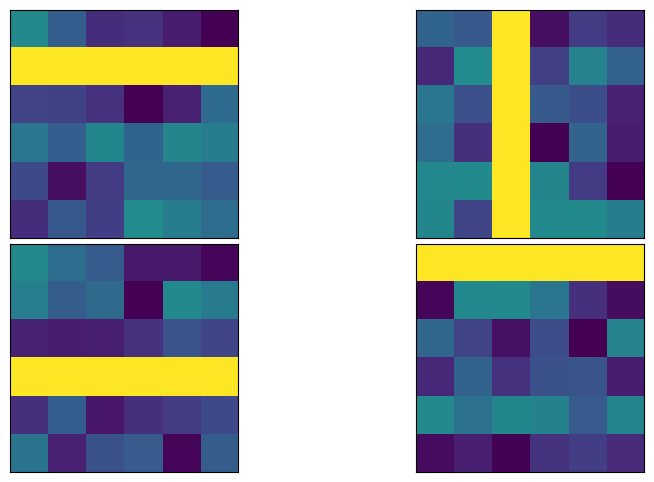

In [31]:
import matplotlib.pyplot as plt
 
# Generate a figure with nested images using subplots.
 
fig, ax = plt.subplots(2, 2, figsize=(10, 6), subplot_kw={"xticks": [], "yticks": []})
for i in range(4):
    ax[i // 2, i % 2].imshow(
        train_images[i].reshape(vert_size, hor_size),
        aspect="equal",
    )
plt.subplots_adjust(wspace=0.1, hspace=0.025)

## Step 1: Map the problem to a quantum circuit

In [32]:
from qiskit.circuit.library import z_feature_map
 
# One qubit per data feature
num_qubits = len(train_images[0])
 
# Data encoding
# Note that qiskit orders parameters alphabetically. We assign the parameter prefix "a" to ensure our data encoding goes to the first part of the circuit, the feature mapping.
feature_map = z_feature_map(num_qubits, parameter_prefix="a")

In [33]:
# This creates a circuit with the cxs in the compressed order.
 
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
 
qnn_circuit = QuantumCircuit(size)
params = ParameterVector("θ", length=2 * size)
for i in range(size):
    qnn_circuit.ry(params[i], i)
 
# CNOT gates between horizontally adjacent qubits.
for i in range(vert_size):
    for j in range(hor_size):
        if j < hor_size - 1:
            qnn_circuit.cx((i * hor_size) + j, (i * hor_size) + j + 1)
 
# CNOT gates between vertically adjacent qubits, likely not necessary based on our preliminary simulation.
#        if i<vert_size-1:
#            qnn_circuit.cx((i*hor_size)+j,(i*hor_size)+j+hor_size)
for i in range(size):
    qnn_circuit.rx(params[size + i], i)
qnn_circuit_large = qnn_circuit
 
print(qnn_circuit_large.decompose().depth())
print(
    f"2+ qubit depth: {qnn_circuit_large.decompose().depth(lambda instr: len(instr.qubits) > 1)}"
)
# qnn_circuit_large.draw()

7
2+ qubit depth: 5


In [34]:
# Combine the feature map and variational circuit
ansatz = qnn_circuit
 
# Combine the feature map with the ansatz
full_circuit = QuantumCircuit(num_qubits)
full_circuit.compose(feature_map, range(num_qubits), inplace=True)
full_circuit.compose(ansatz, range(num_qubits), inplace=True)
 
# Check the depth of the full circuit
print(full_circuit.decompose().depth())
print(
    f"2+ qubit depth: {full_circuit.decompose().depth(lambda instr: len(instr.qubits) > 1)}"
)

11
2+ qubit depth: 5


Because we are using the `z_feature_map`, which has no CNOT gates, adding the encoding layer does not increase our two-qubit depth. The full circuit is given by

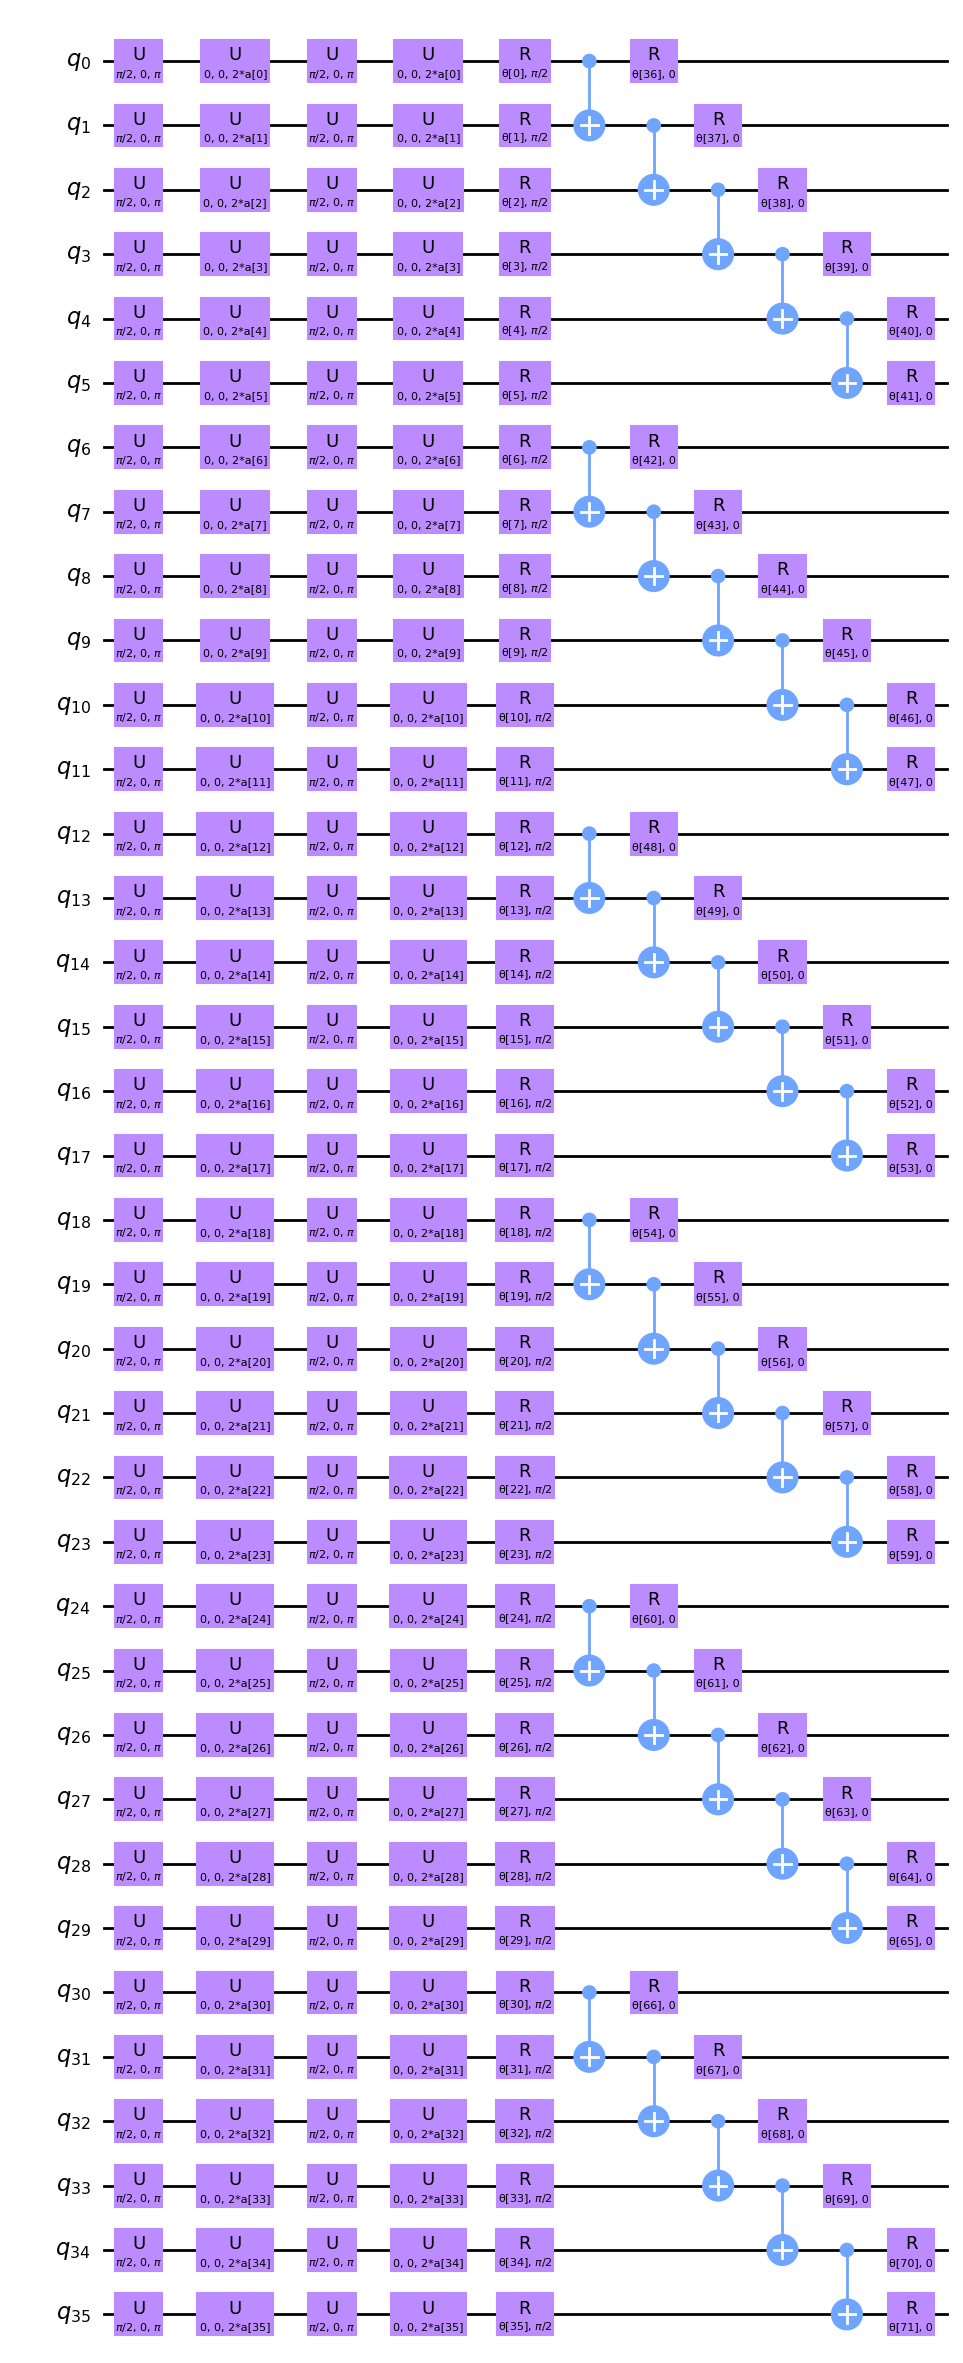

In [35]:
full_circuit.decompose().draw("mpl", style="clifford", idle_wires=False, fold=-1)

We could make changes to the CNOT gates to optimize the circuit, but leave it for now.

Let's re-define our observable with our larger images:

In [36]:
from qiskit.quantum_info import SparsePauliOp
 
observable = SparsePauliOp.from_list([("Z" * (num_qubits), 1)])

## Qiskit Patterns Step 2: Optimize problem for quantum execution

Select a backend

In [37]:
from qiskit_ibm_runtime import QiskitRuntimeService
 
# To run on hardware, select the least busy quantum computer or specify a particular one.
service = QiskitRuntimeService()
backend = service.least_busy(operational=True, simulator=False)
# backend = service.backend("ibm_brisbaneane")
 
print(backend.name)

management.get:WARNING:2026-02-06 17:46:58,472: Loading default saved account


ibm_fez


Again, we define a pass manager with optimization level 3:

In [38]:
from qiskit.circuit.library import XGate
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import (
    ALAPScheduleAnalysis,
    ConstrainedReschedule,
    PadDynamicalDecoupling,
)
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
 
target = backend.target
 
pm = generate_preset_pass_manager(target=target, optimization_level=3)
pm.scheduling = PassManager(
    [
        ALAPScheduleAnalysis(target=target),
        ConstrainedReschedule(
            acquire_alignment=target.acquire_alignment,
            pulse_alignment=target.pulse_alignment,
            target=target,
        ),
        PadDynamicalDecoupling(
            target=target,
            dd_sequence=[XGate(), XGate()],
            pulse_alignment=target.pulse_alignment,
        ),
    ]
)

Now, we iterate over many pass manager runs since there can be large variability in the transpiled two-qubit depths. We will use the best (shallowest) result in the end.

In [39]:
# Try pass manager several times, since heuristics can return various transpilations on large circuits, and we want the shallowest.
 
transpiled_qcs = []
transpiled_depths = []
transpiled_2q_depths = []
for i in range(1, 10):
    circuit_ibm = pm.run(full_circuit)
    transpiled_qcs.append(circuit_ibm)
    transpiled_depths.append(circuit_ibm.decompose().depth())
    transpiled_2q_depths.append(
        circuit_ibm.decompose().depth(lambda instr: len(instr.qubits) > 1)
    )
    # print(i)
 
print(transpiled_depths)
print(transpiled_2q_depths)
 
# Use the shallowest
 
minpos = transpiled_2q_depths.index(min(transpiled_2q_depths))

[57, 57, 57, 57, 57, 57, 57, 57, 57]
[5, 5, 5, 5, 5, 5, 5, 5, 5]


Again, there is no difference, so let's just take the first one

In [40]:
circuit_ibm = transpiled_qcs[0]
observable_ibm = observable.apply_layout(circuit_ibm.layout)
print(circuit_ibm.decompose().depth())
print(
    f"2+ qubit depth: {circuit_ibm.decompose().depth(lambda instr: len(instr.qubits) > 1)}"
)

57
2+ qubit depth: 5


## Qiskit Patterns Step 3: Execute using Qiskit Primitives

In [43]:
# This was run on an Eagle r3 processor on 10-4-24, and took 7 min.
 
from qiskit_ibm_runtime import EstimatorV2 as Estimator, Session
 
batch_size = 7
num_epochs = 1
num_samples = len(train_images)
 
# Globals
circuit = circuit_ibm
observable = observable_ibm
objective_func_vals = []
iter = 0
 
# Random initial weights for the ansatz
np.random.seed(42)
# weight_params = np.random.rand(len(ansatz.parameters)) * 2 * np.pi
# Or re-load weights from a previous calculation
weight_params = np.array(
    [
        3.35330497,
        5.97351416,
        4.59925358,
        3.76148219,
        0.98029403,
        0.98014248,
        0.3649501,
        6.44234523,
        3.77691701,
        4.44895122,
        0.12933619,
        6.09412333,
        5.23039137,
        1.33416598,
        1.14243996,
        1.15236452,
        1.91161039,
        3.2971419,
        3.71399059,
        1.82984665,
        3.84438512,
        0.87646578,
        1.83559896,
        2.30191935,
        2.86557222,
        4.93340606,
        1.25458737,
        3.23103027,
        3.72225051,
        0.29185655,
        3.81731689,
        1.07143467,
        0.40873121,
        5.96202367,
        6.067245,
        5.07931034,
        1.91394476,
        0.61369199,
        4.2991629,
        2.76555968,
        0.76678884,
        3.11128829,
        0.21606945,
        5.71342859,
        1.62596258,
        4.16275028,
        1.95853845,
        3.26768375,
        3.43508199,
        1.1614748,
        6.09207989,
        4.87030317,
        5.90304595,
        5.62236606,
        3.75671636,
        5.79230665,
        0.55601479,
        1.23139664,
        0.28417144,
        2.04411075,
        2.44213144,
        1.70493625,
        5.20711134,
        2.24154726,
        1.76516358,
        3.40986006,
        0.88545302,
        5.04035228,
        0.46841551,
        6.2007935,
        4.85215699,
        1.24856745,
    ]
)
 
# # Running in a session avoids repeated queuing. This is available to Premium Plan, Flex Plan, and On-Prem (IBM Quantum Platform API) Plan users.
 
# with Session(backend=backend) as session:
#     estimator = Estimator(mode=session, options={"resilience_level": 1})
 
#     for epoch in range(num_epochs):
#         for i in range((num_samples - 1) // batch_size + 1):
#             print(f"Epoch: {epoch}, batch: {i}")
#             start_i = i * batch_size
#             end_i = start_i + batch_size
#             train_images_batch = np.array(train_images[start_i:end_i])
#             train_labels_batch = np.array(train_labels[start_i:end_i])
#             input_params = train_images_batch
#             target = train_labels_batch
#             iter = 0
#             # We can increase maxiter to do a full optimization.
#             res = minimize(
#                 mse_loss_weights,
#                 weight_params,
#                 method="COBYLA",
#                 options={"maxiter": 20},
#             )
#             weight_params = res["x"]
# session.close()
 
# Open users can carry out the same calculation using a batch, but repeated queuing is possible.
from qiskit_ibm_runtime import Batch
 
with Batch(backend=backend) as batch:
   estimator = Estimator(
       mode=batch, options={"resilience_level": 1}
   )

   for epoch in range(num_epochs):
       for i in range((num_samples - 1) // batch_size + 1):
           print(f"Epoch: {epoch}, batch: {i}")
           start_i = i * batch_size
           end_i = start_i + batch_size
           train_images_batch = np.array(train_images[start_i:end_i])
           train_labels_batch = np.array(train_labels[start_i:end_i])
           input_params = train_images_batch
           target = train_labels_batch
           iter = 0
           # We can increase maxiter to do a full optimization.
           res = minimize(
               mse_loss_weights,
               weight_params,
               method="COBYLA",
               options={"maxiter": 20},
           )
           weight_params = res["x"]
batch.close()

Epoch: 0, batch: 0
Iter: 0, loss: 0.9309677180915937


capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


IBMRuntimeError: 'Failed to run program: \'400 Client Error: Bad Request for url: https://quantum.cloud.ibm.com/api/v1/jobs. {"errors":[{"code":1217,"message":"Session has been closed.","solution":"Increase the session `max_time` if possible, or keep session active by reducing the time between jobs.  For details, see the [Session length](https://quantum.cloud.ibm.com/docs/guides/run-jobs-session#session-length) guide.","more_info":"https://cloud.ibm.com/apidocs/quantum-computing#error-handling"}],"trace":"93dda72e-d518-494a-ae8f-22b926795867"}\\n\''

In [ ]:
weight_params

In [ ]:
obj_func_vals_qc = objective_func_vals
# import matplotlib.pyplot as plt
 
plt.figure(figsize=(12, 6))
plt.plot(obj_func_vals_qc, label="revised ansatz")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.legend()
plt.show()

## Closing

Let's summarize our findings:

1. Step 1: Map the problem to a quantum circuit
   * Load training data. this could be done "by hand" or using a pre-built feature map like `z_feature_map`.
   * Construct an ansatz containing rotation and entanglement layers that are appropriate for your problem.
   * Monitor circuit depth to ensure quality results on quantum computers.
2. Step 2: Optimize problem for quantum execution
   * Select a backend, often the least busy one.
   * Use a pass manager to transpile both the circuit and the observables to the architechture of the chosen backend.
   * For very deep or wide circuits, transpile multiple times, and select the shallowest circuit.
3. Step 3: Execute using Qiskit (Runtime) Primitives
   * Carry out preliminary trials on simulators to debug and optimize your ansatz.
   * Execute on an (IBM) quantum computer.
4. Step 4: Post-process, return result in classical format
   * Calculate model accuracy on training data, and on testing data.
   * Monitor convergence of the classical optimization.